## 5. CRISP-DM: Modeling

<div style="color:red;">???? ⬇️<div> - For the Baseline Performance Test (see Aufgabenstellung) we apply the exact same modeling techniques to the raw csv and clkeaned csv (data preparation) and compare their AUC score. Does this meet the requirements?
<div style="color:red;">???? ⬇️<div> - What value should we try to reach for the ROC AUC? Does it suffice if we significantly improve the result from the raw csv


## Unprepared Data

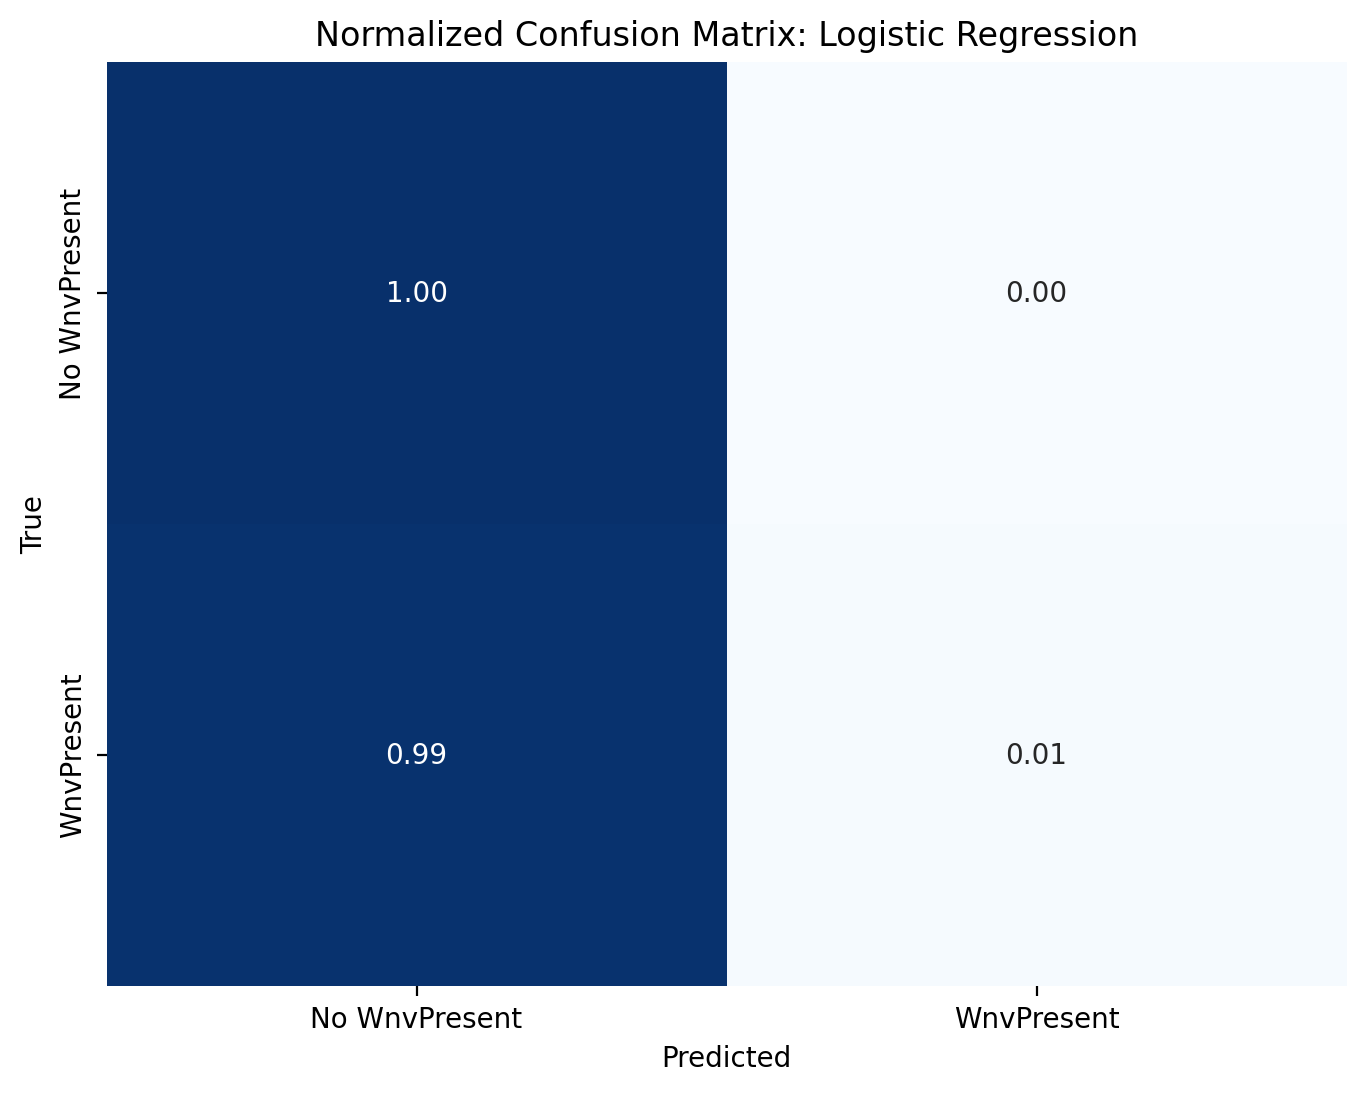

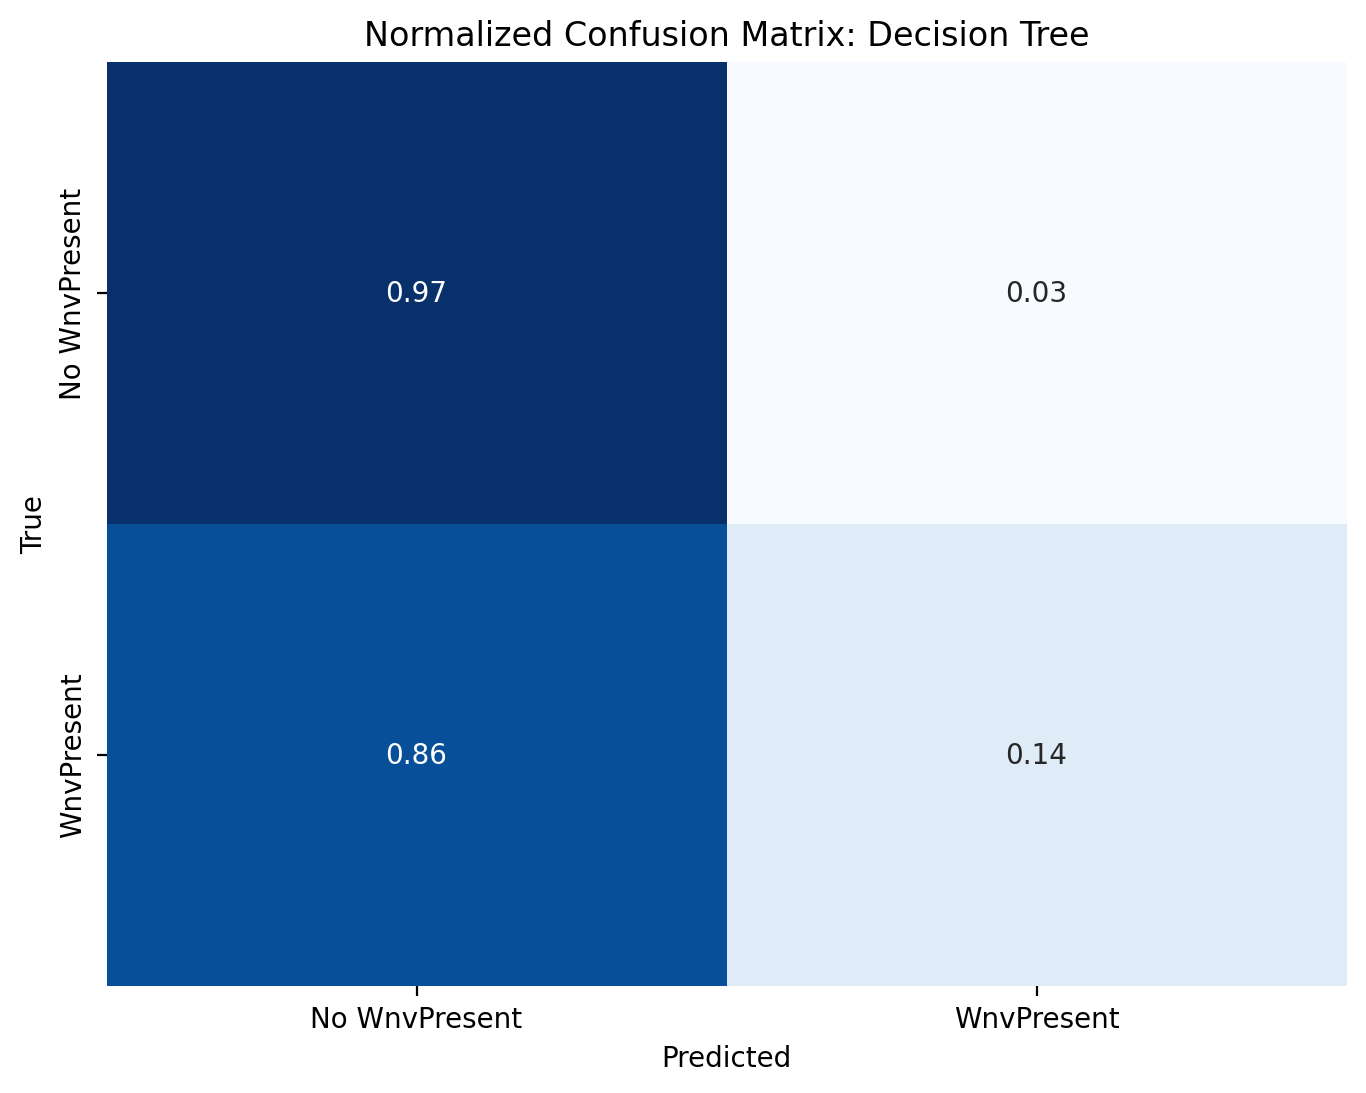

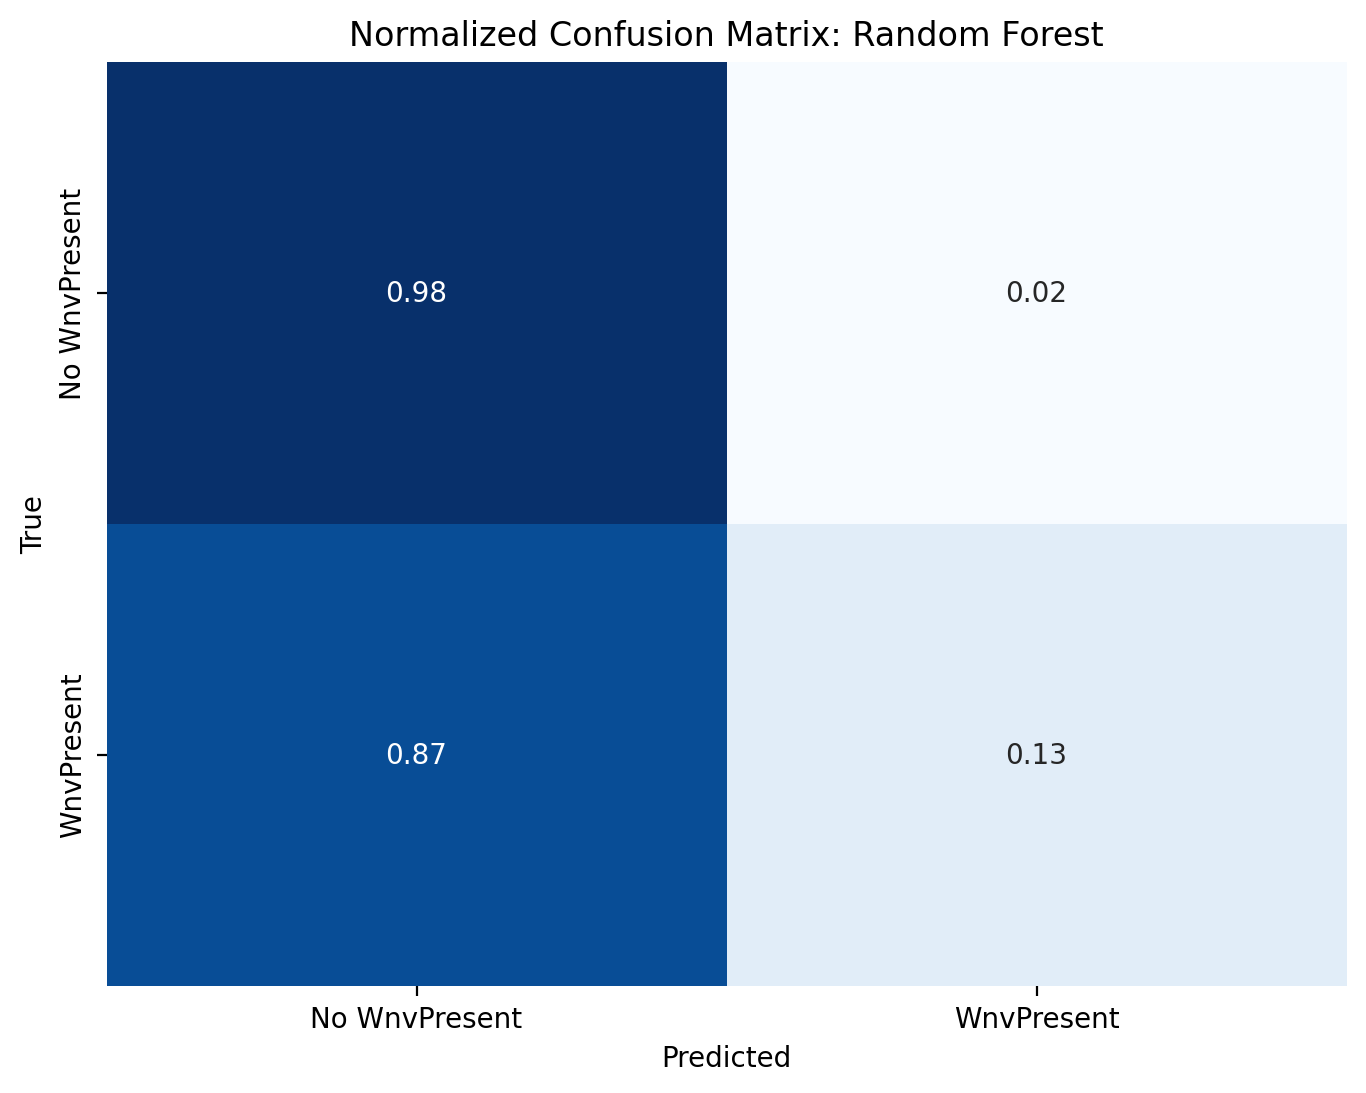

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


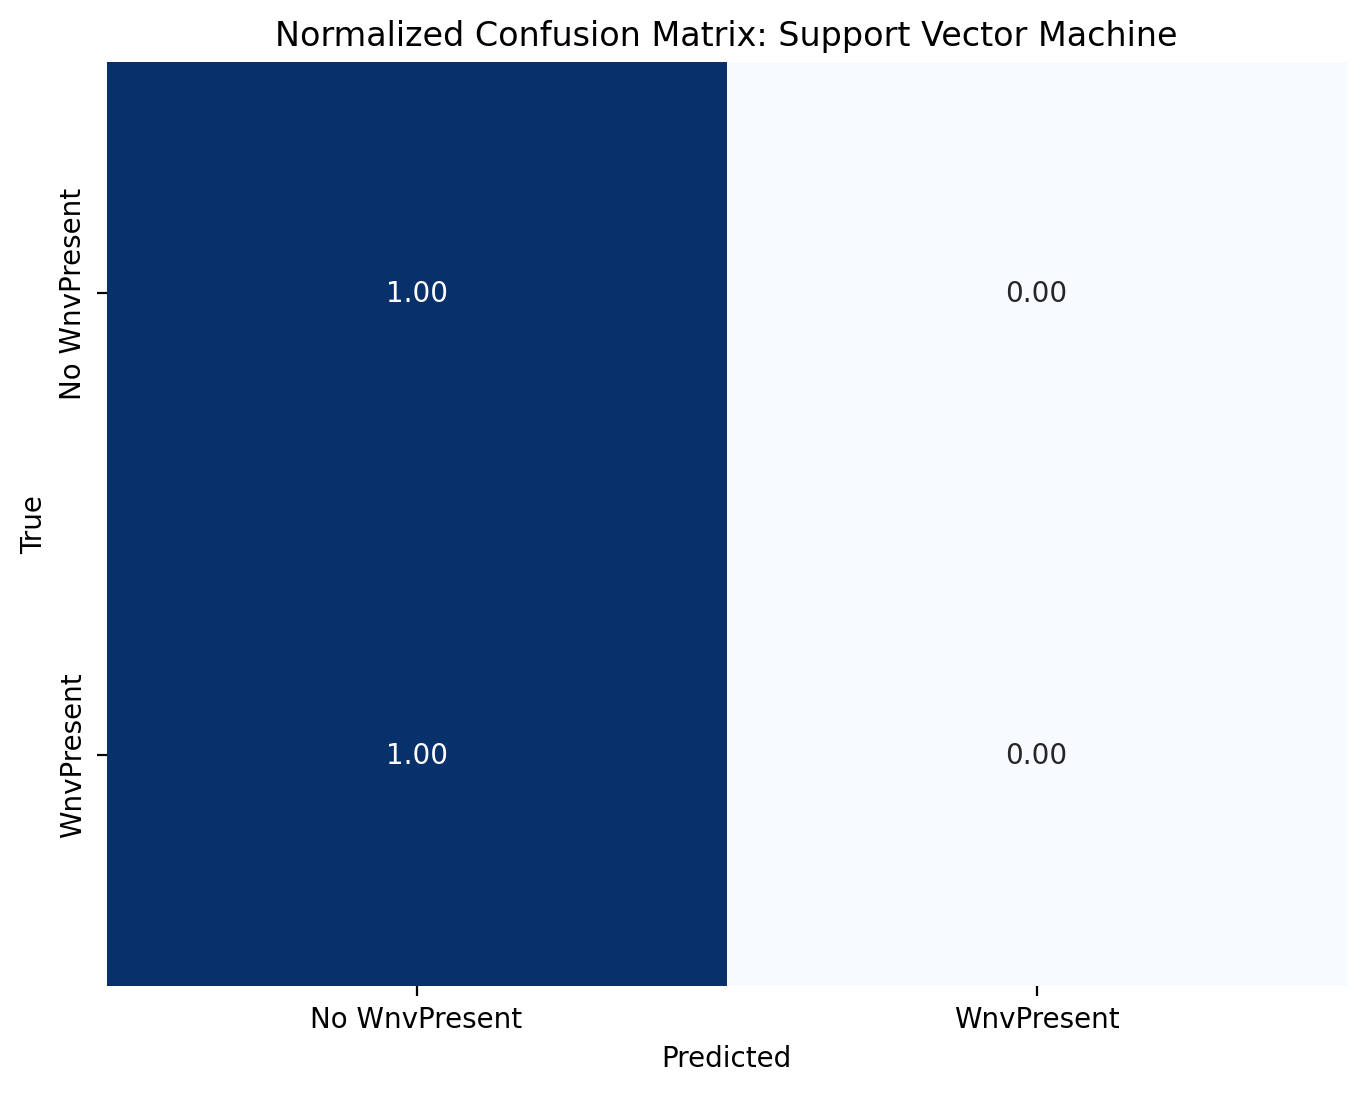

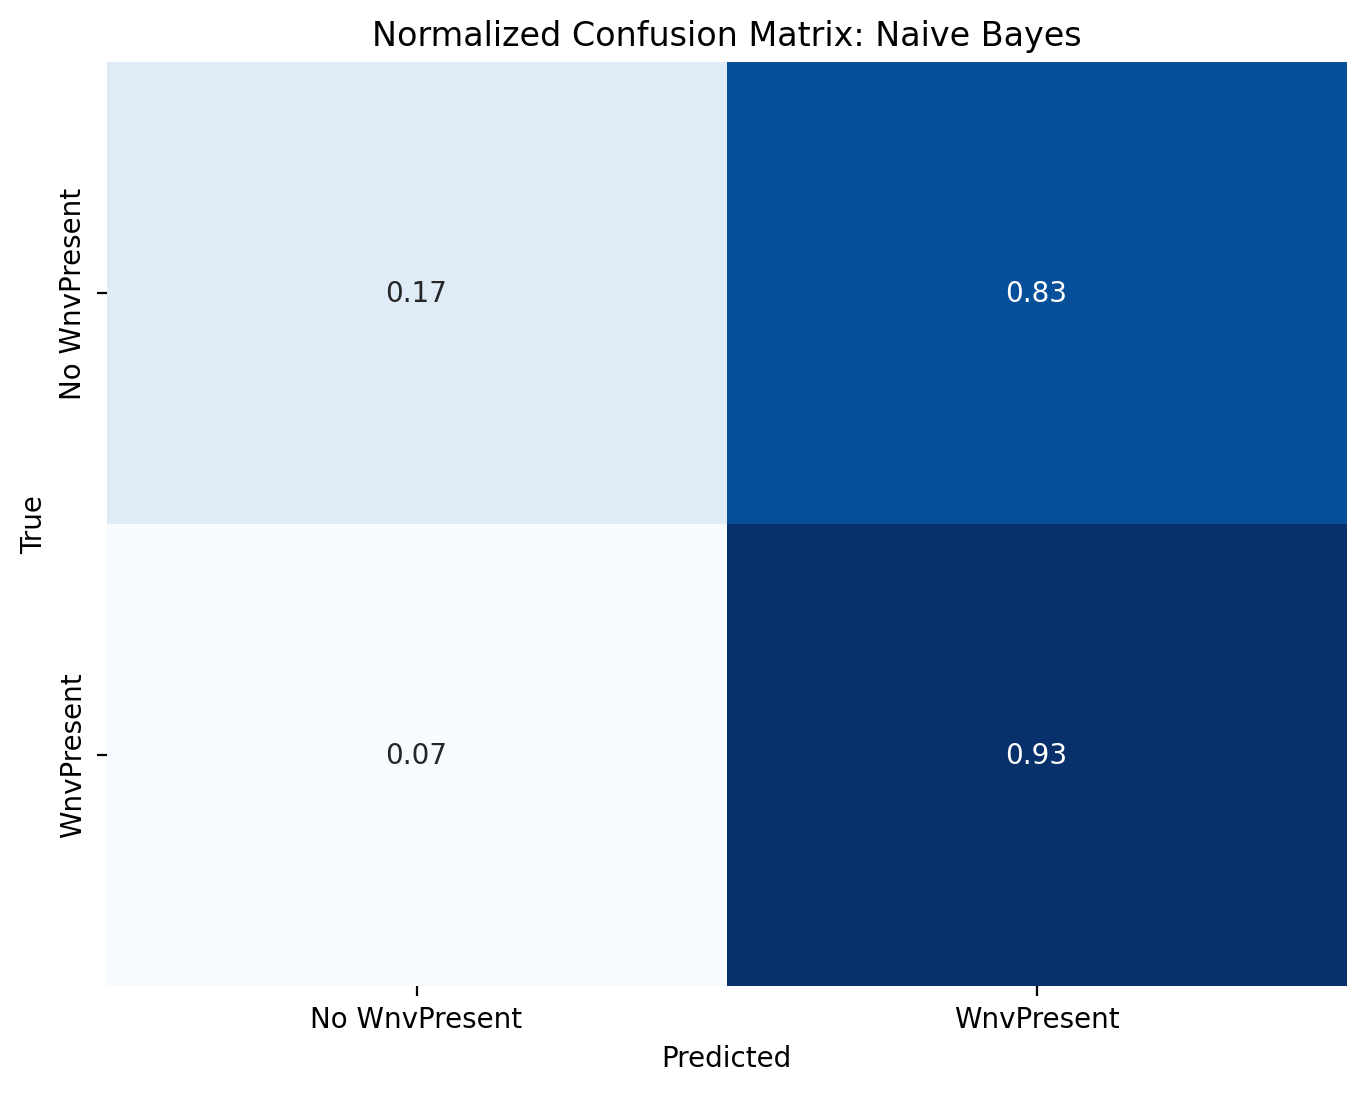

,Accuracy,ROC AUC,F1 Score,Precision,Recall
Logistic Regression,0.947335,0.735404,0.023529,0.500000,0.012048
Decision Tree,0.928617,0.590029,0.169742,0.219048,0.138554
Random Forest,0.934010,0.678335,0.168000,0.250000,0.126506
Support Vector Machine,0.947335,0.603553,0.000000,0.000000,0.000000
Naive Bayes,0.213832,0.550928,0.110553,0.058779,0.927711


## Prepared Data

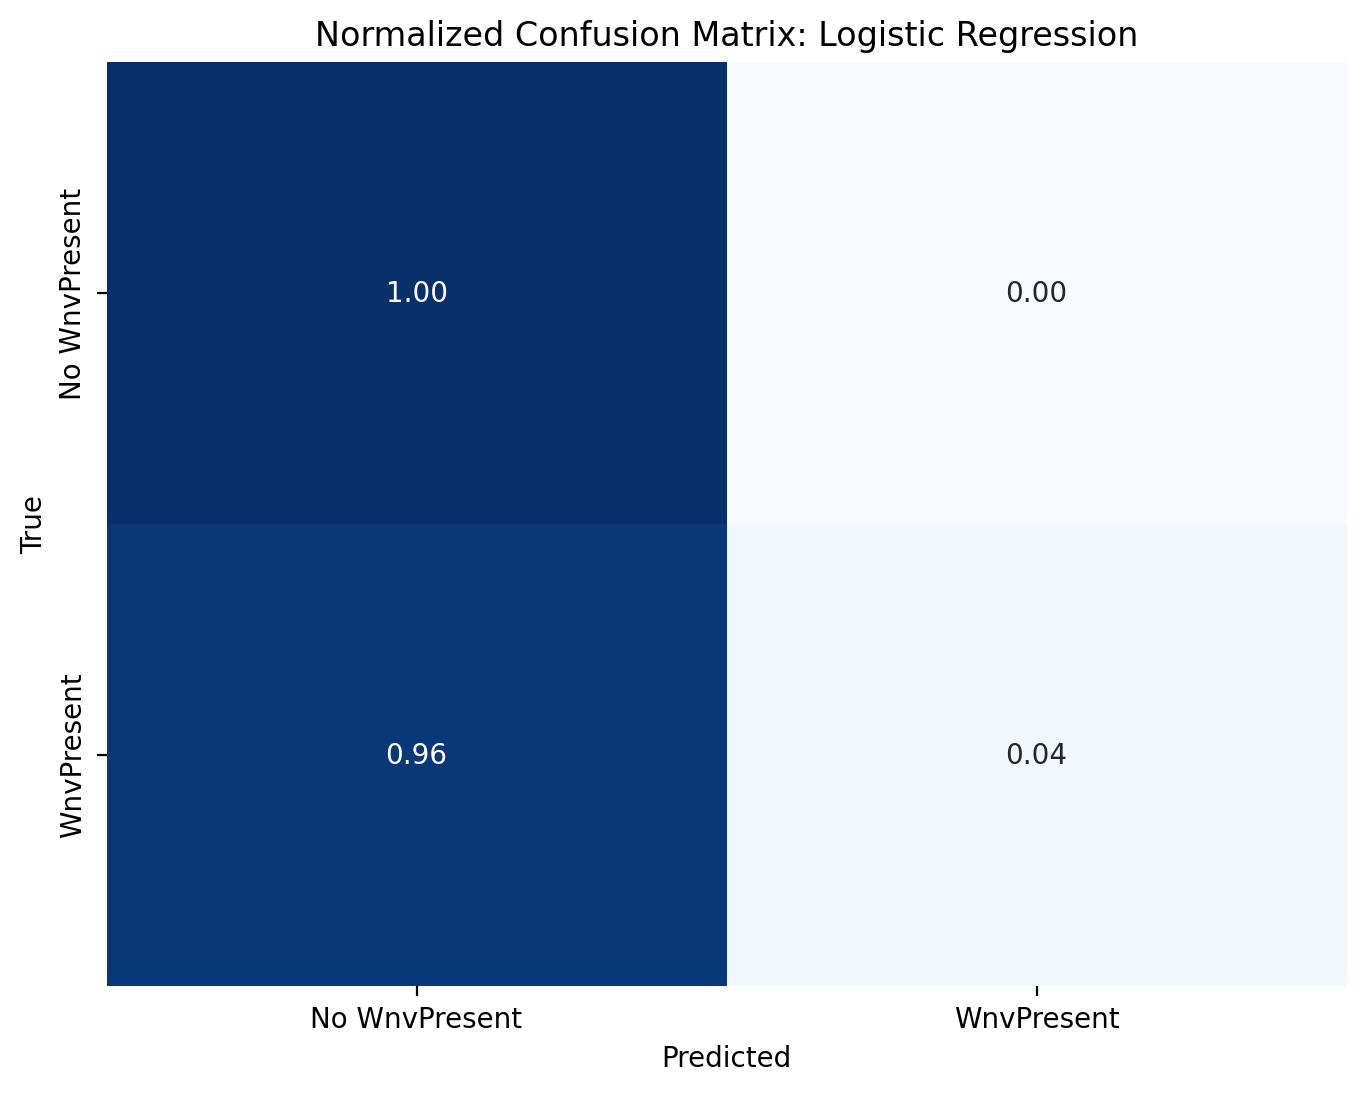

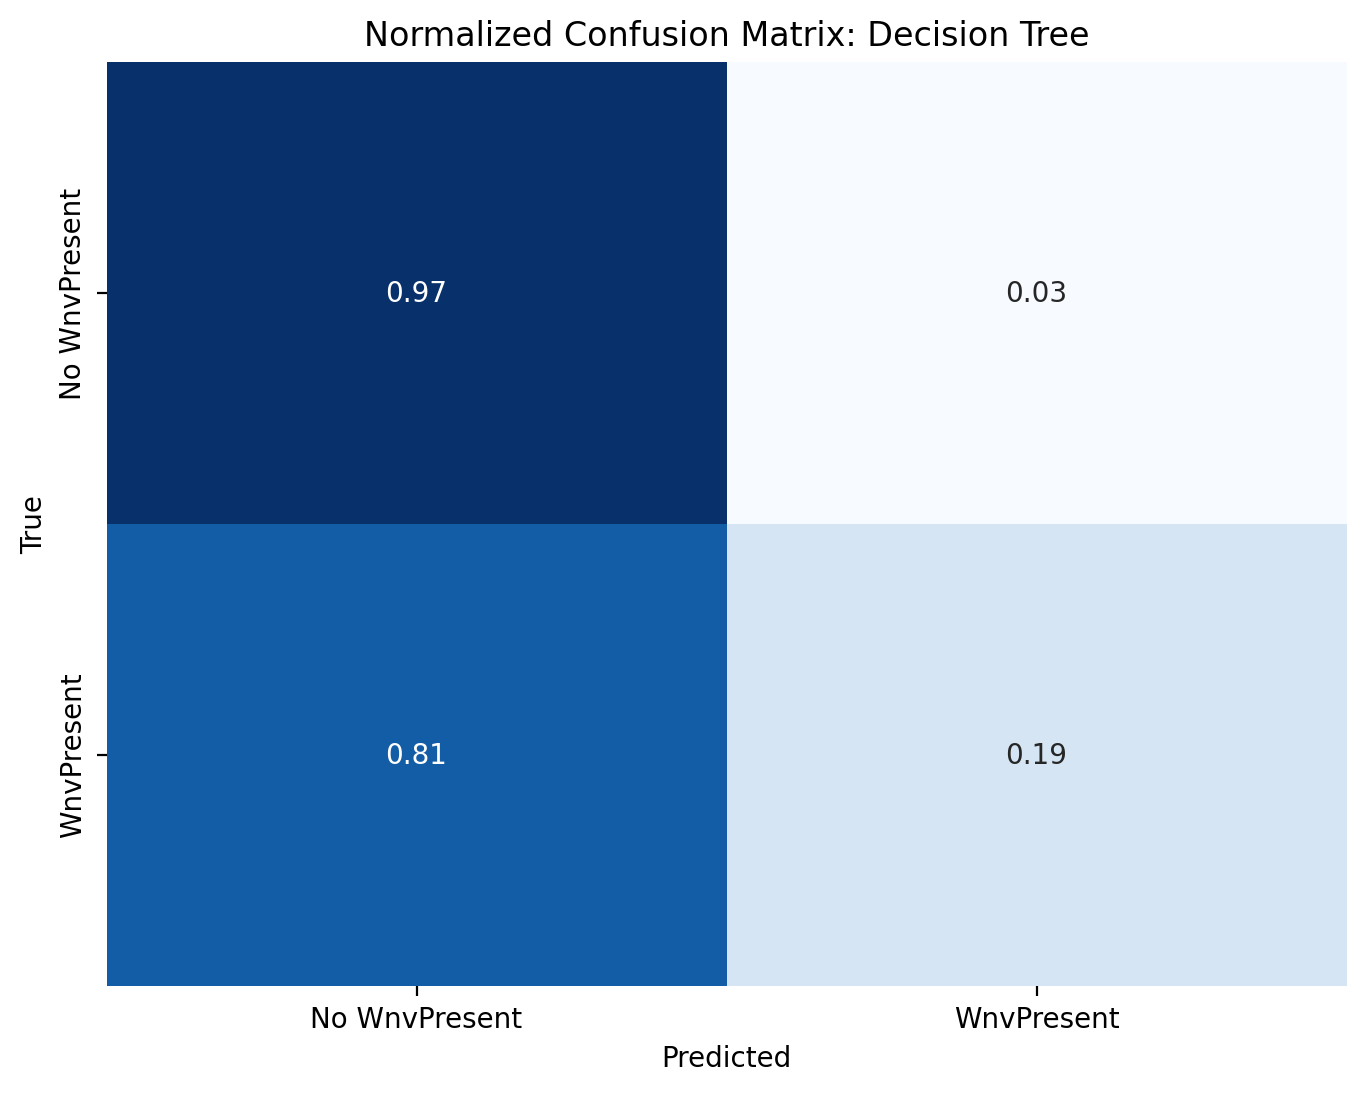

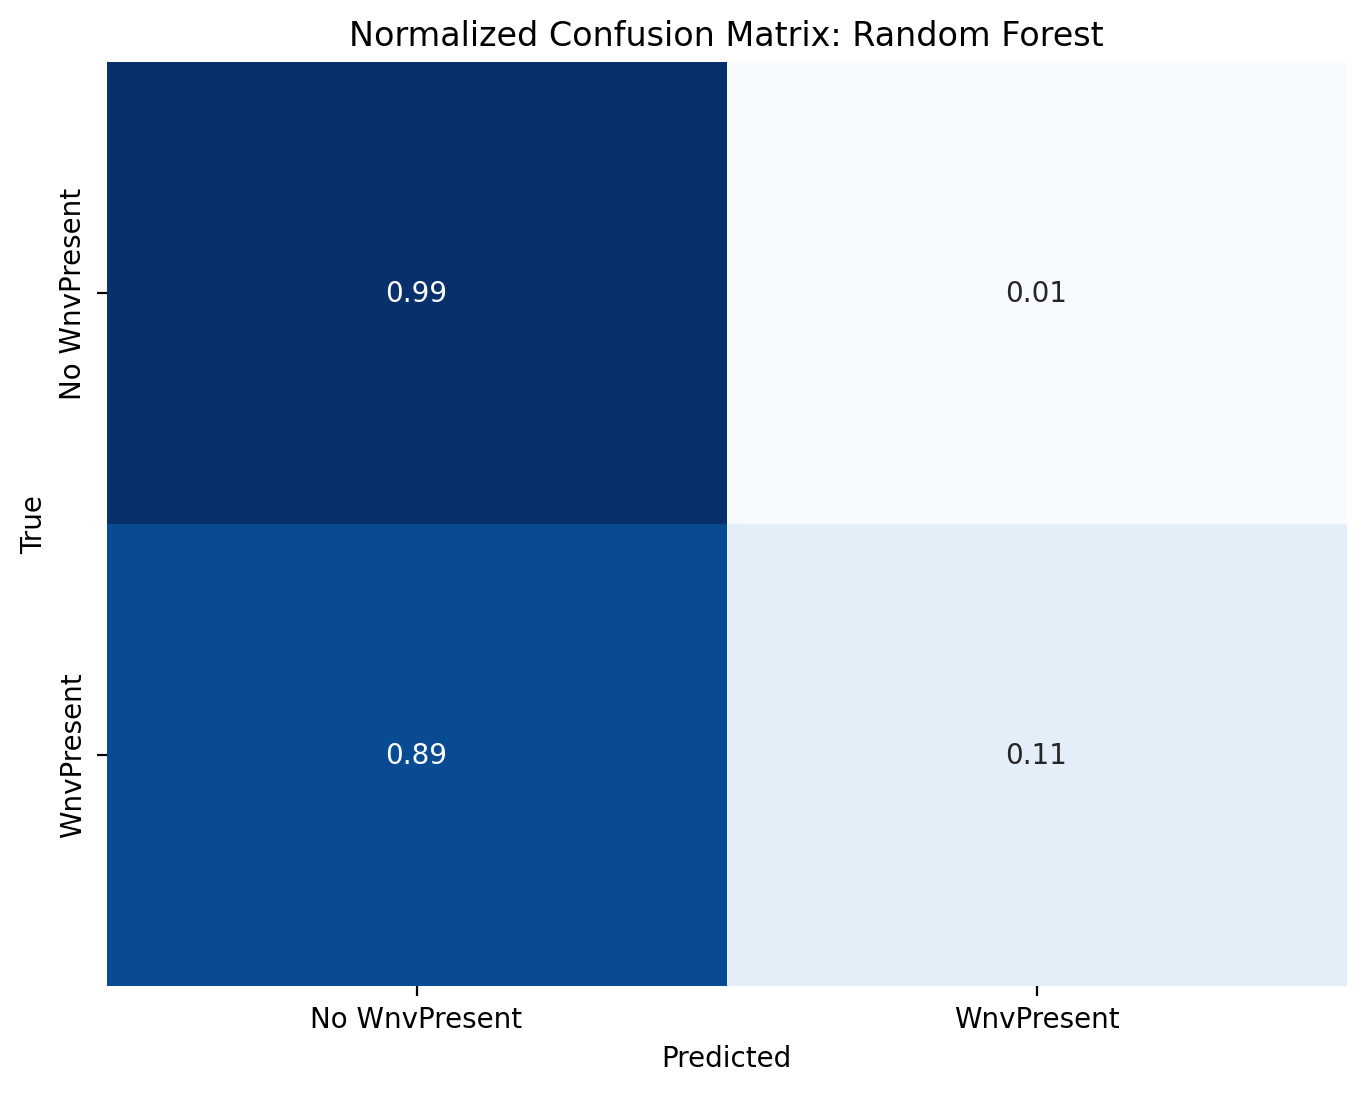

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


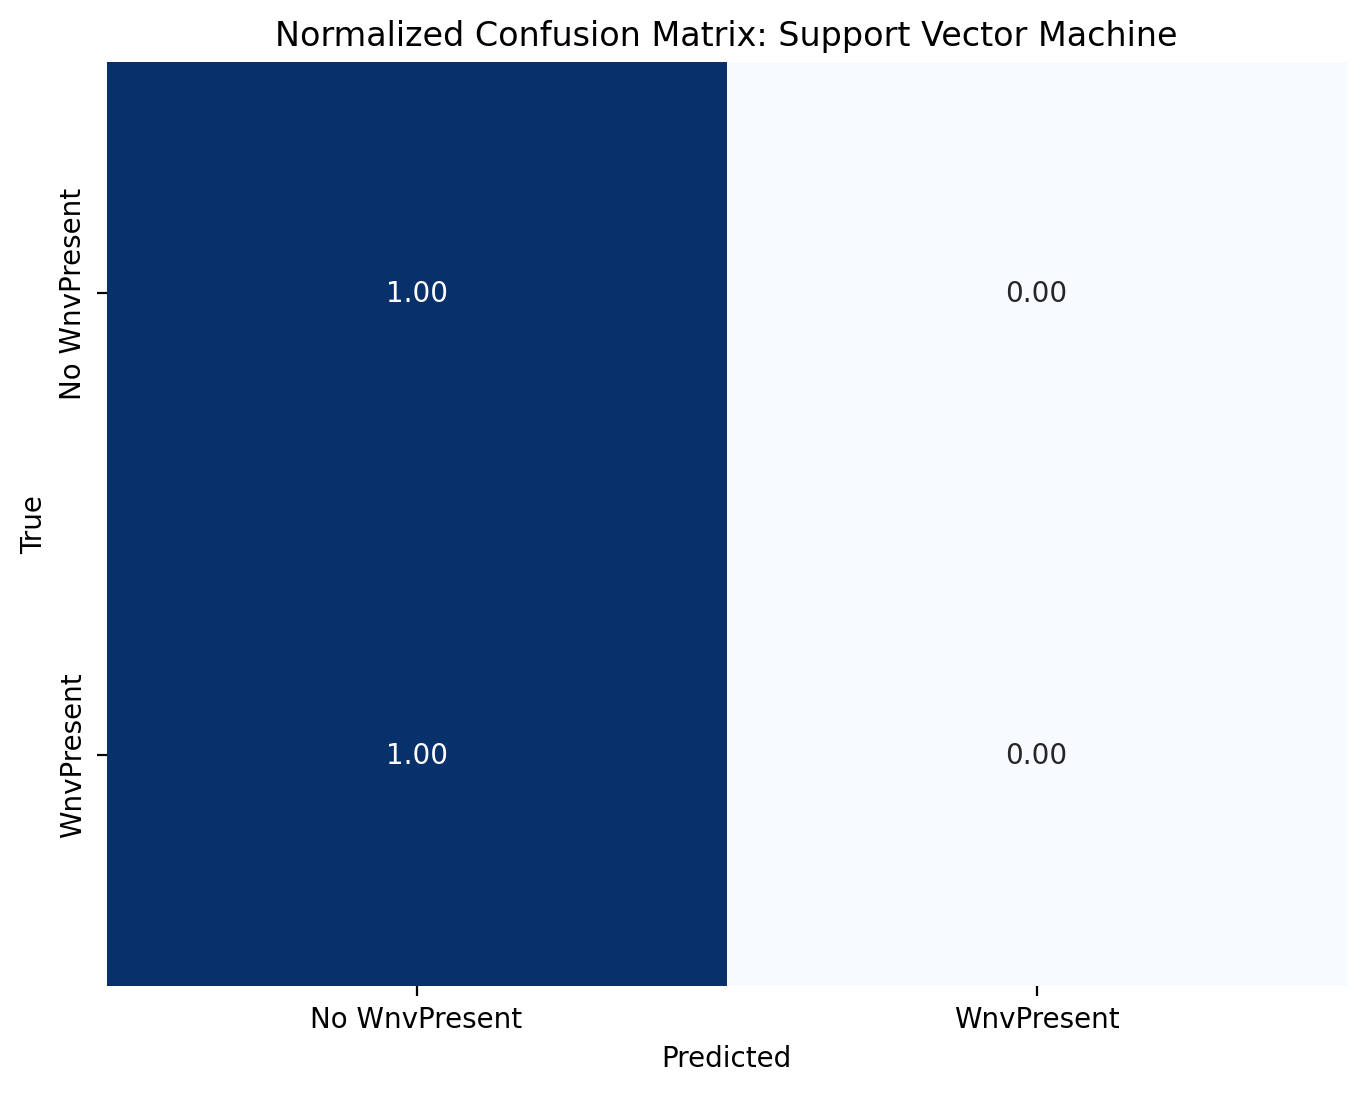

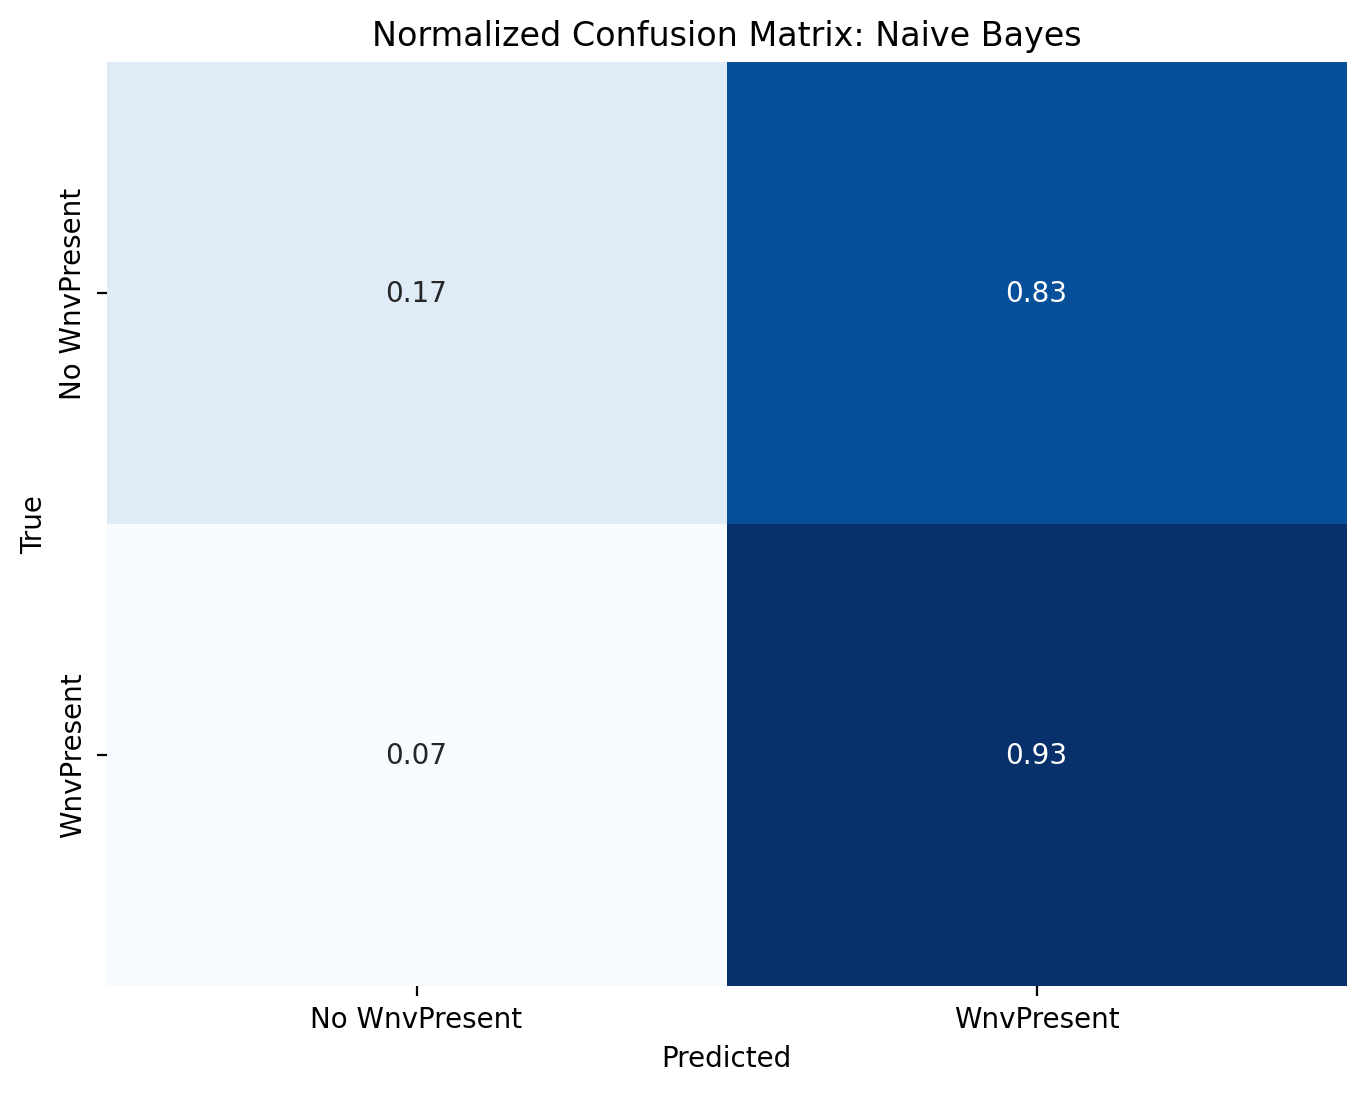

,Accuracy,ROC AUC,F1 Score,Precision,Recall
Logistic Regression,0.945749,0.780886,0.065574,0.352941,0.036145
Decision Tree,0.930203,0.611239,0.225352,0.271186,0.192771
Random Forest,0.947335,0.813753,0.178218,0.500000,0.108434
Support Vector Machine,0.947335,0.770268,0.000000,0.000000,0.000000
Naive Bayes,0.213832,0.550928,0.110553,0.058779,0.927711


In [1]:
# Existing imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB  # Import for Naive Bayes
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score
import joblib
import os
from IPython.display import display, Markdown
import seaborn as sns

# Settings for plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # High resolution figures

def prepare_data(train, test):
    # Data preparation
    train.drop('Date', axis=1, inplace=True)  # Assuming Date isn't required
    X = train.drop(["WnvPresent"], axis=1)
    y = train['WnvPresent']
    X_encoded = pd.get_dummies(X, drop_first=True)
    # Apply the same transformation to test data
    test_encoded = pd.get_dummies(test.drop(['Date', 'Id'], axis=1), drop_first=True)
    # Ensure test data has the same columns in the same order
    test_encoded = test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

    # Standardize the features
    # OVERFITTING: Standardization avoids overfitting by ensuring that all features have the same scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    test_scaled = scaler.transform(test_encoded)  # Use the same scaler to transform test data

    # Split the dataset into training and testing sets -> Zunächst wird das Modell wird mit 70% der Daten trainiert und anschließend validiert.
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test, test_scaled

def prepare_models():
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Support Vector Machine': SVC(probability=True),
        # 'Naive Bayes': GaussianNB()
    }
    return models

def train_models(models, X_train, y_train):
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

def plot_confusion_matrix(y_true, y_pred, class_names, classifier_name):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Normalized Confusion Matrix: {classifier_name}')
    plt.show()

def evaluate_models(trained_models, X_test, y_test):
    results = {}
    class_names = ['No WnvPresent', 'WnvPresent']  # Update as per your class names
    for name, model in trained_models.items():
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob),
            'F1 Score': f1_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred)
        }
        plot_confusion_matrix(y_test, y_pred, class_names, name)  # Plotting the confusion matrix
    results_df = pd.DataFrame(results).T
    return results_df

# Continue with your main workflow

display(Markdown("## Unprepared Data"))
# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
# Main workflow
X_train, X_test, y_train, y_test, test_scaled = prepare_data(train, test)
models = prepare_models()
trained_models = train_models(models, X_train, y_train)
results_df = evaluate_models(trained_models, X_test, y_test)

# Display results
display(results_df)

display(Markdown("## Prepared Data"))
# Load datasets
train_cleaned = pd.read_csv('../data/cleaned_train.csv')
test_cleaned = pd.read_csv('../data/cleaned_test.csv')
# Main workflow
X_train, X_test, y_train, y_test, test_scaled = prepare_data(train_cleaned, test_cleaned)
models = prepare_models()
trained_models = train_models(models, X_train, y_train)
results_df = evaluate_models(trained_models, X_test, y_test)
# Display results
display(results_df)
